# Training a Machine Learning Surrogate

To train a machine learning surrogate, we need to import several essential libraries. We will use `numpy` and `pandas` for data manipulation, and `tensorflow` for constructing and training the neural network. Additionally, we will utilize the `KerasSurrogate` object from the `idaes.core.surrogate` module in IDAES for surrogate modeling.

In [1]:
# Import statements
import os
import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf

# Import IDAES libraries
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.sampling.scaling import OffsetScaler
from idaes.core.surrogate.keras_surrogate import (
    KerasSurrogate,
)
from idaes.core.surrogate.plotting.sm_plotter import (
    surrogate_scatter2D,
    surrogate_parity,
    surrogate_residual,
)

# fix environment variables to ensure consist neural network training
os.environ["PYTHONHASHSEED"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(46)
rn.seed(1342)
tf.random.set_seed(62)

After importing the libraries, we will begin by reading the data generated from the Monte Carlo Simulation of the desalination model from an Excel file. We will then remove any points where the model was found to be infeasible using the `dropna` function from pandas. Given that the simulations are on the order of 1e3, we will use the entire dataset; however, users can choose the number of samples they want to use for training the surrogate model. Finally, we will define the input and output variables for the surrogate model and extract the input and output labels from the column names of the dataset.

In [2]:
# Import Auto-reformer training data
np.set_printoptions(precision=6, suppress=True)

# Reading the data from excel and sampling from it.
# mvc_data.xlsx is a dummy file name.
# One should replace this with the actual file name
csv_data = pd.read_excel("./mvc_data.xlsx")
csv_data.dropna(inplace=True)
csv_data = csv_data[csv_data["Status"] == 1]
data = csv_data.sample(n=len(csv_data))

# Defining the input and the output columns
input_data = data[["Inlet", "Recovery", "Flow"]]
output_data = data[["CAPEX", "OPEX"]]

# Define labels
input_labels = input_data.columns
output_labels = output_data.columns

We visualize the data to make sure the data is as expected. 

In [3]:
# Visualizing the dataframe to make sure things are in order
data

,Inlet,Outlet,Flow,CAPEX,OPEX,Energy,Recovery,Status
17,79.034560,88.177089,26.407876,237.090816,811.554472,579.681766,0.103684,1
1388,40.461753,45.653131,17.059299,218.872856,652.276517,465.911798,0.113714,1
1735,62.087226,77.231861,0.000000,0.000000,0.000000,0.000000,0.196093,1
751,136.551056,191.493272,18.662841,136.399113,566.470550,404.621822,0.286915,1
470,45.298362,63.524457,1.817602,35.210561,68.346101,48.818643,0.286915,1
...,...,...,...,...,...,...,...,...
442,68.910338,149.381482,6.365363,79.772393,225.582757,161.130541,0.538696,1
1396,199.052007,279.141893,17.059299,144.059951,677.736465,484.097475,0.286915,1
1576,99.572011,325.455186,0.000000,0.000000,0.000000,0.000000,0.694053,1
837,148.773453,208.633432,3.198730,38.719320,103.379963,73.842831,0.286915,1


The next step is to set up the neural network architecture, where we specify the activation function, optimizer, number of hidden layers, and number of nodes per layer. These are hyperparameters that should be configured by the user. We then define the loss function and the metrics for evaluating the model's performance. Since this is a regression model, we use mean squared error (MSE) as the loss function, and mean absolute error (MAE) and mean squared error (MSE) as the metrics.

Next, we split the dataset into training and testing sets, using an 80/20 split, and then further split the data into input and output dataframes. Then define the length of the input and output layer of the neural network. The next step is to normalize the data using `create_normalizing_scaler` object. 

We create a Keras `Sequential` object and add the input layer, followed by the hidden layers, and finally the output layer. We compile the model by specifying the loss function, optimizer, and metrics. We also set up a checkpoint to save the state of the model, storing the best-known weights based on the minimum validation loss in the `.model_checkpoint.hdf5` file.

Next, we fit the model using the training and validation data, specifying the number of epochs and the callback.

We then determine the minimum and maximum values of each input variable in the dataset to set the bounds for the input variables. These bounds are passed to the `KerasSurrogate` object along with the neural network model, input and output labels, input and output scalers, and input bounds. Finally, we save the `KerasSurrogate` object to a folder.

In [4]:
# Select the hyper parameters to be used for training model
activation, optimizer, n_hidden_layers, n_nodes_per_layer = "relu", "Adam", 3, 10
loss, metrics = "mse", ["mae", "mse"]

# Spliting the data into train and test with 80-20 split.
data_training, data_testing = split_training_validation(data, 0.8, seed=1)
X_train, X_test, Y_train, Y_test = (
    data_training[input_labels],
    data_testing[input_labels],
    data_training[output_labels],
    data_testing[output_labels],
)

# Defining input and output layer lengths of the neural network
n_inputs = len(input_labels)
n_outputs = len(output_labels)

# Scaling the data using normal scaler (x-xmin)/(xmax-xmin)
# Converting scaled data
# to numpy from indexed series.
input_scaler = None
output_scaler = None
input_scaler = OffsetScaler.create_normalizing_scaler(X_train)
output_scaler = OffsetScaler.create_normalizing_scaler(Y_train)
X_train = input_scaler.scale(X_train)
Y_train = output_scaler.scale(Y_train)
x_train = X_train.to_numpy()
y_train = Y_train.to_numpy()
x_test = input_scaler.scale(X_test)
y_test = output_scaler.scale(Y_test)

# Create Keras Sequential object and build neural network
model = tf.keras.Sequential()
model.add(
    tf.keras.layers.Dense(
        units=n_nodes_per_layer, input_dim=n_inputs, activation=activation
    )
)
for i in range(1, n_hidden_layers):
    model.add(tf.keras.layers.Dense(units=n_nodes_per_layer, activation=activation))
model.add(tf.keras.layers.Dense(units=n_outputs))

# Train surrogate (calls optimizer on neural network and solves for weights)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
mcp_save = tf.keras.callbacks.ModelCheckpoint(
    ".model_checkpoint.hdf5", save_best_only=True, monitor="val_loss", mode="min"
)
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    verbose=2,
    epochs=500,
    callbacks=[mcp_save],
)
# save model to JSON and create callable surrogate object
xmin, xmax = [0.00, 0.05, 0], [200, 0.95, 32.00]
input_bounds = {input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))}

keras_surrogate = KerasSurrogate(
    model,
    input_labels=list(input_labels),
    output_labels=list(output_labels),
    input_bounds=input_bounds,
    input_scaler=input_scaler,
    output_scaler=output_scaler,
)
keras_surrogate.save_to_folder("keras_surrogate")

Epoch 1/500
48/48 - 1s - loss: 0.0969 - mae: 0.2325 - mse: 0.0969 - val_loss: 0.0514 - val_mae: 0.1737 - val_mse: 0.0514 - 1s/epoch - 25ms/step
Epoch 2/500


c:\Users\javal.vyas\AppData\Local\anaconda3\envs\pareto-env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 - 0s - loss: 0.0377 - mae: 0.1461 - mse: 0.0377 - val_loss: 0.0239 - val_mae: 0.1114 - val_mse: 0.0239 - 168ms/epoch - 4ms/step
Epoch 3/500
48/48 - 0s - loss: 0.0188 - mae: 0.0996 - mse: 0.0188 - val_loss: 0.0132 - val_mae: 0.0860 - val_mse: 0.0132 - 180ms/epoch - 4ms/step
Epoch 4/500
48/48 - 0s - loss: 0.0108 - mae: 0.0755 - mse: 0.0108 - val_loss: 0.0085 - val_mae: 0.0685 - val_mse: 0.0085 - 150ms/epoch - 3ms/step
Epoch 5/500
48/48 - 0s - loss: 0.0072 - mae: 0.0613 - mse: 0.0072 - val_loss: 0.0062 - val_mae: 0.0575 - val_mse: 0.0062 - 166ms/epoch - 3ms/step
Epoch 6/500
48/48 - 0s - loss: 0.0054 - mae: 0.0522 - mse: 0.0054 - val_loss: 0.0049 - val_mae: 0.0508 - val_mse: 0.0049 - 131ms/epoch - 3ms/step
Epoch 7/500
48/48 - 0s - loss: 0.0043 - mae: 0.0455 - mse: 0.0043 - val_loss: 0.0042 - val_mae: 0.0458 - val_mse: 0.0042 - 142ms/epoch - 3ms/step
Epoch 8/500
48/48 - 0s - loss: 0.0037 - mae: 0.0414 - mse: 0.0037 - val_loss: 0.0037 - val_mae: 0.0423 - val_mse: 0.0037 - 118ms/epoch -

INFO:tensorflow:Assets written to: keras_surrogate\assets


Now, we load the model from the folder and evaluate it using the entire dataset to assess the model's fit. This is done using the $R^2$ metric, where a value closer to 1 indicates a better fit.

In [5]:
# Loading the model from the folder and evaluating it.
from idaes.core.surrogate.metrics import compute_fit_metrics

surr = KerasSurrogate.load_from_folder("Keras_surrogate")
y_true = data_training[output_labels]  ### The true values from the dataframe.
y_pred = surr.evaluate_surrogate(data_training[input_labels])  ### The predicted values

# Calculating the R2 score to check the fit of the model.
y_mean = y_true.mean(axis=0)
SST = ((y_true - y_mean) ** 2).sum(axis=0)
SSE = ((y_true - y_pred) ** 2).sum(axis=0)

r2 = 1 - SSE / SST

print(f"The training R2 scores are")
print(r2)

y_true = data_testing[output_labels]  ### The true values from the dataframe.
y_pred = surr.evaluate_surrogate(data_testing[input_labels])  ### The predicted values

# Calculating the R2 score to check the fit of the model.
y_mean = y_true.mean(axis=0)
SST = ((y_true - y_mean) ** 2).sum(axis=0)
SSE = ((y_true - y_pred) ** 2).sum(axis=0)

r2 = 1 - SSE / SST

print(f"The test R2 scores are")
print(r2)

48/48 [==============================] - 0s 2ms/step
The training R2 scores are
CAPEX    0.998854
OPEX     0.998263
dtype: float64
12/12 [==============================] - 0s 1ms/step
The test R2 scores are
CAPEX    0.998526
OPEX     0.997984
dtype: float64


Next, we visualize the model using the `surrogate_scatter2D` plot to examine the fit. We also use the `surrogate_parity` plot to check the deviation of the model predictions from the ground truth and the `surrogate_residual` plot to analyze the residuals. We do this for both the training set and the testing set. 

48/48 [==============================] - 0s 1ms/step


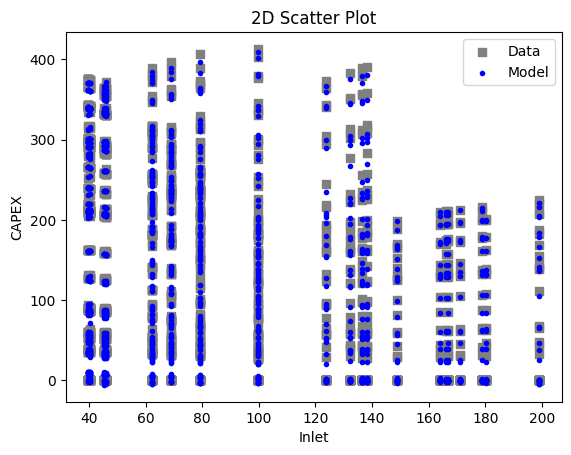

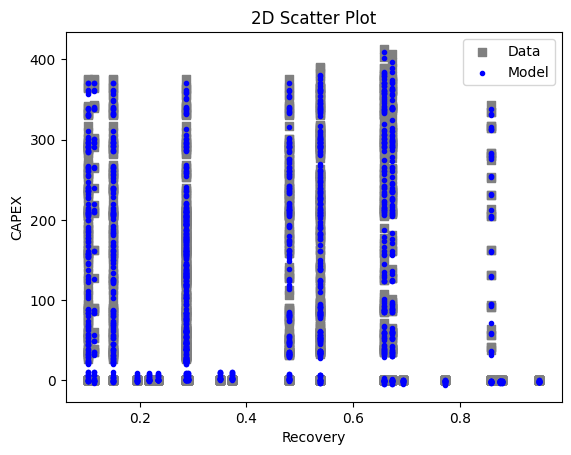

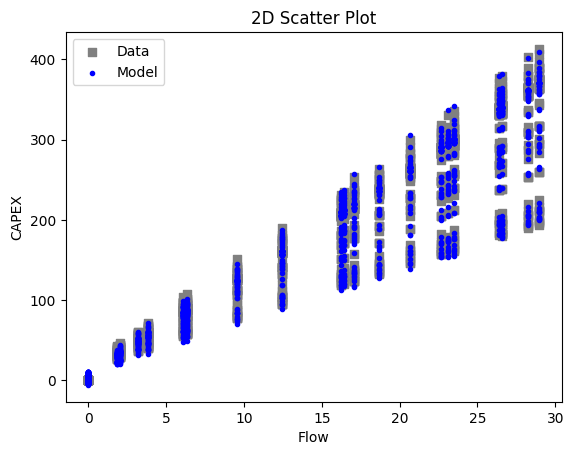

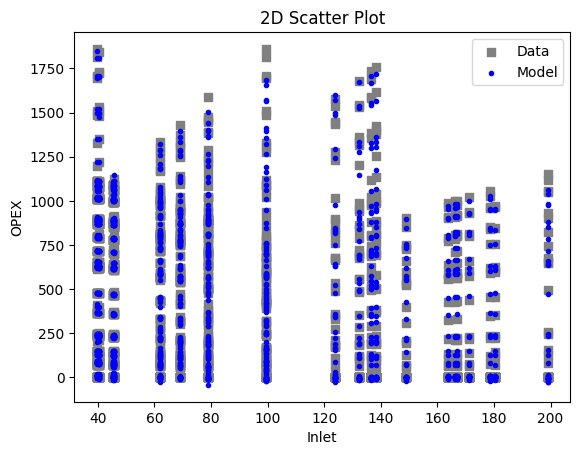

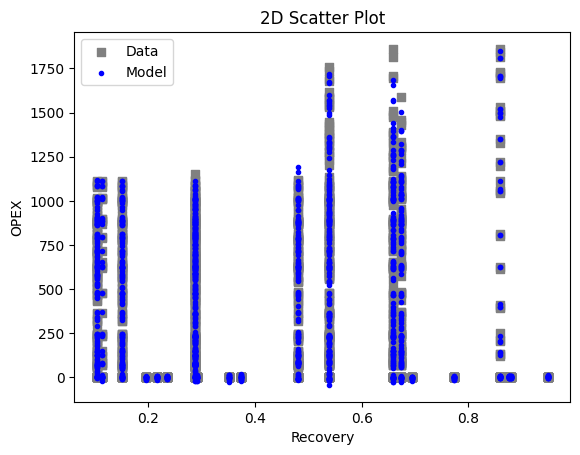

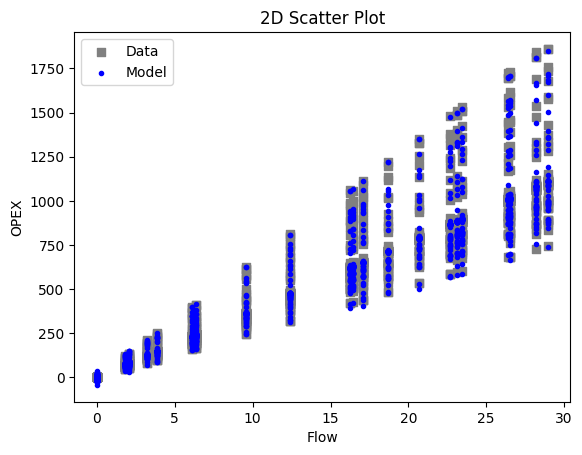

48/48 [==============================] - 0s 1ms/step


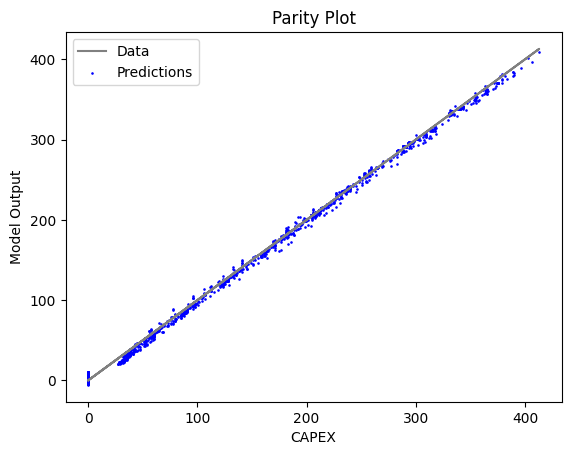

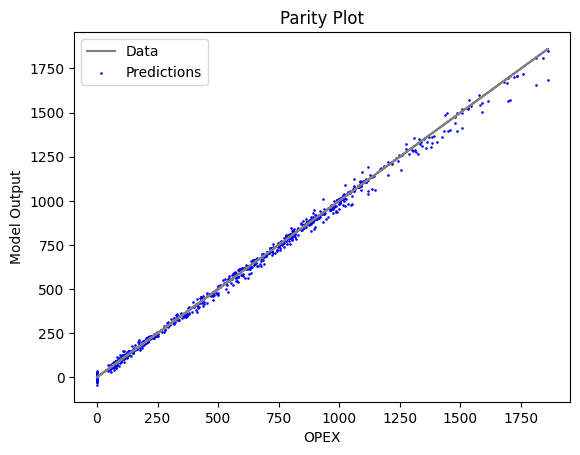

48/48 [==============================] - 0s 1ms/step


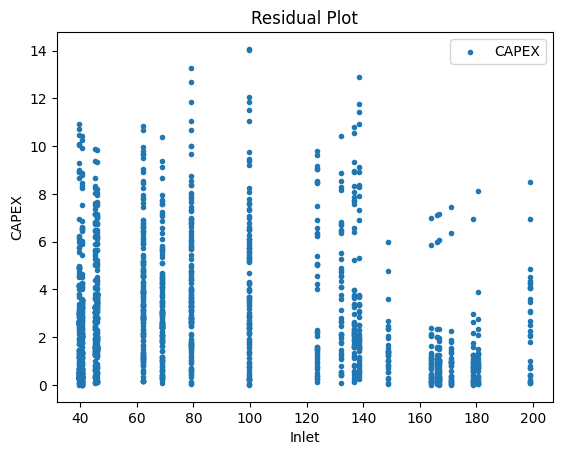

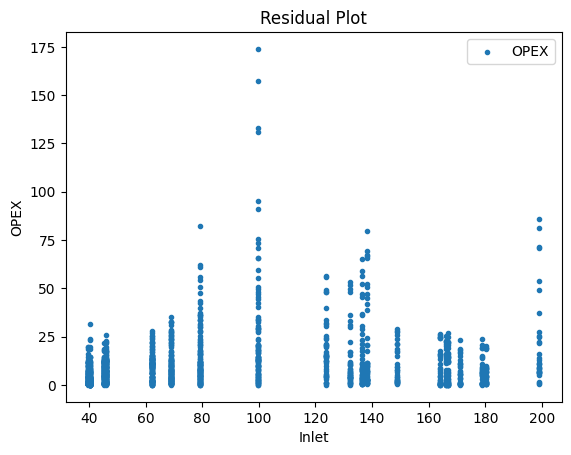

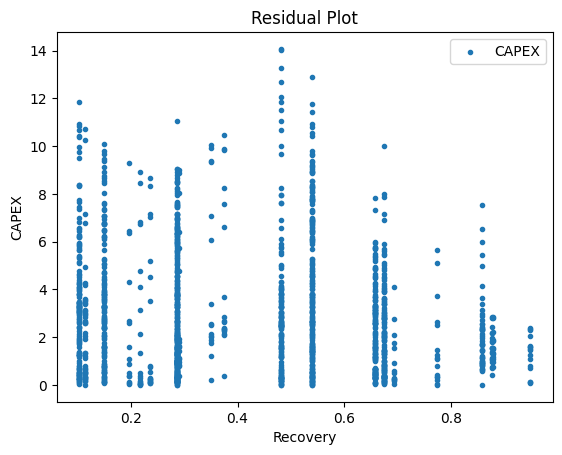

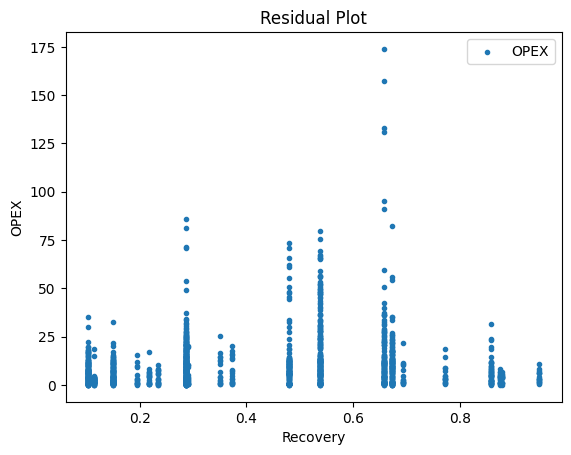

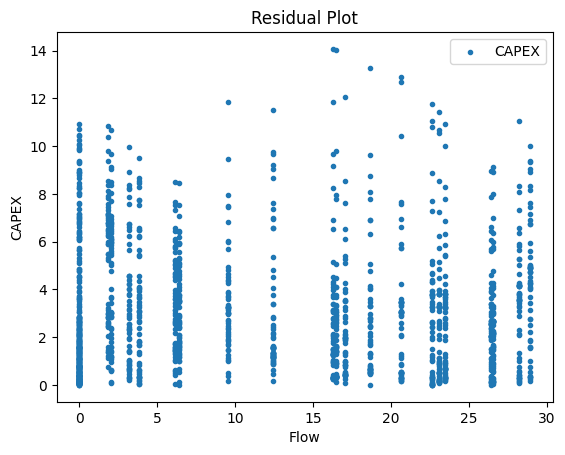

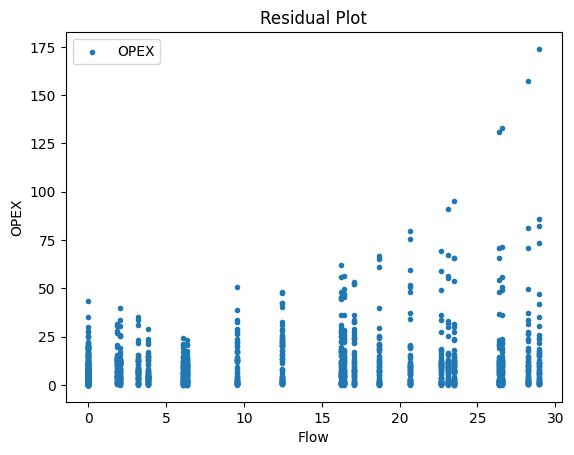

12/12 [==============================] - 0s 1ms/step


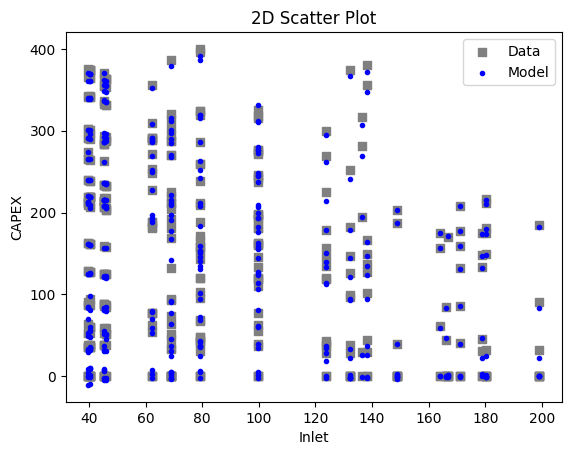

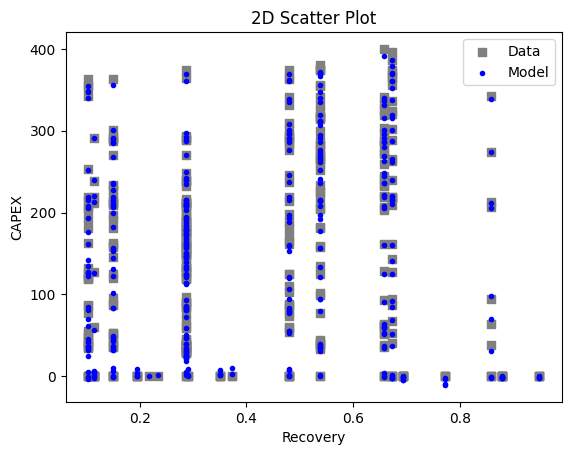

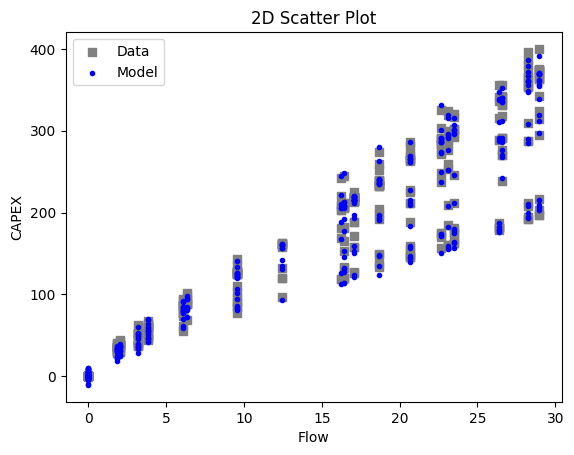

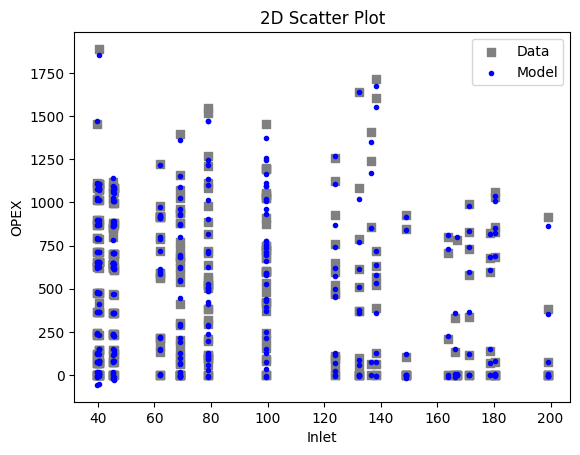

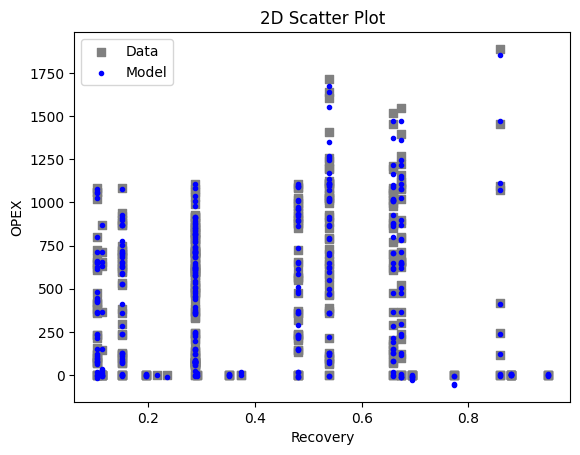

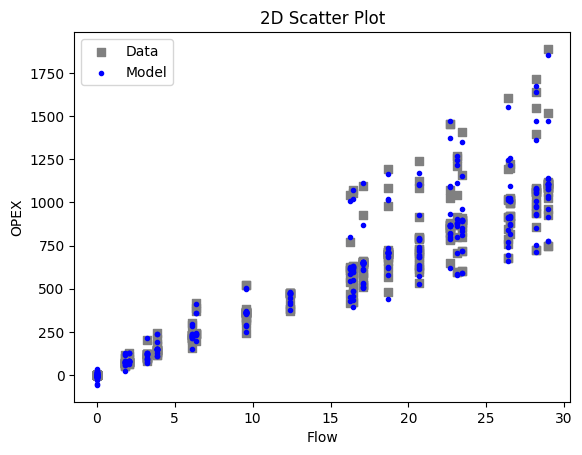

12/12 [==============================] - 0s 1ms/step


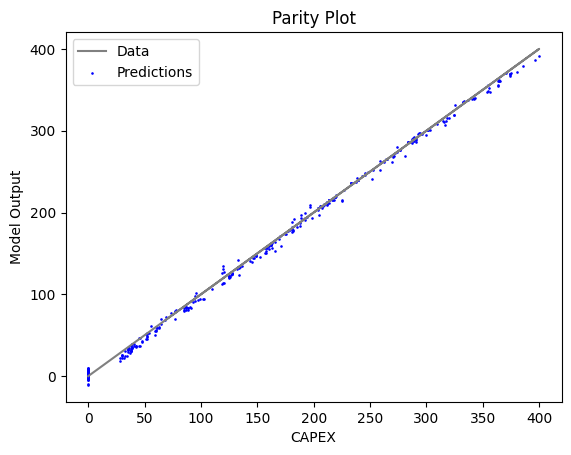

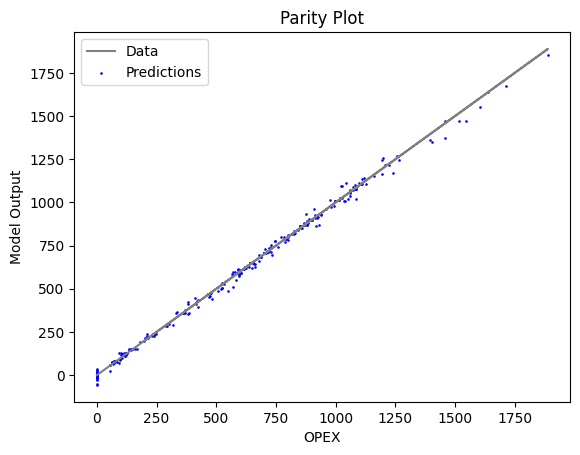

12/12 [==============================] - 0s 0s/step


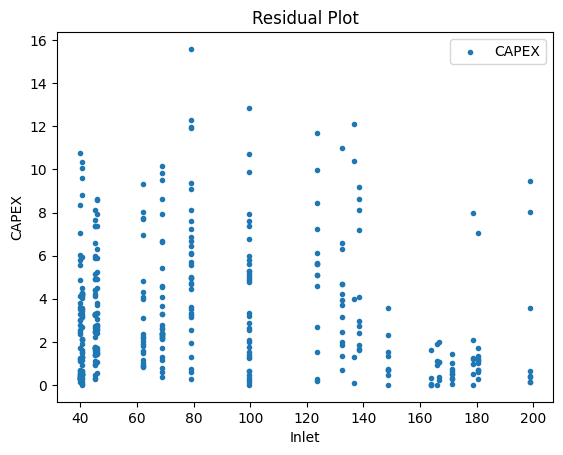

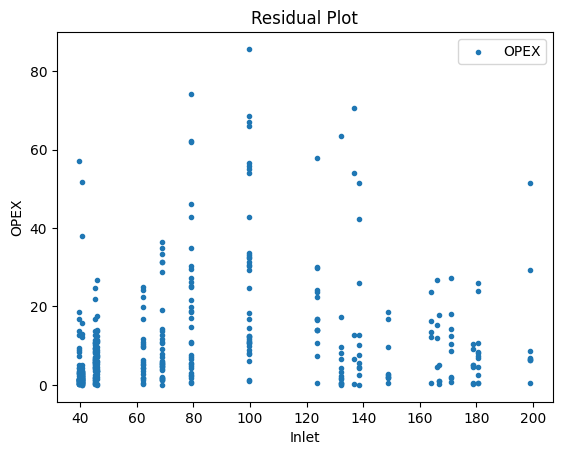

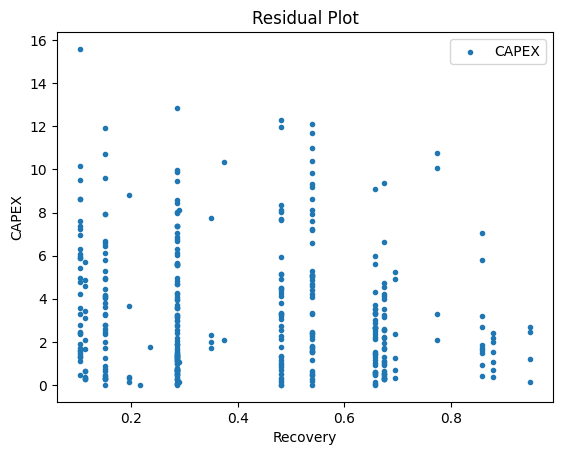

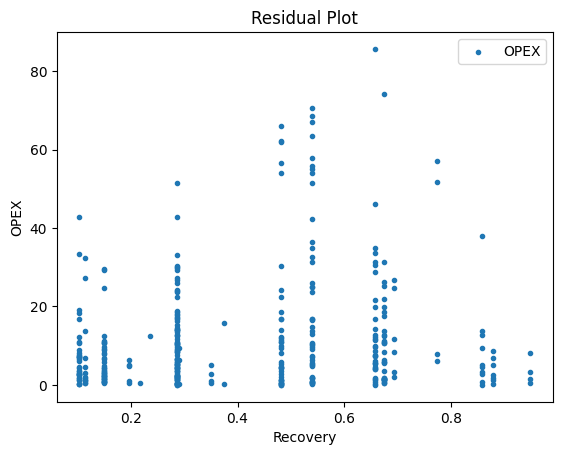

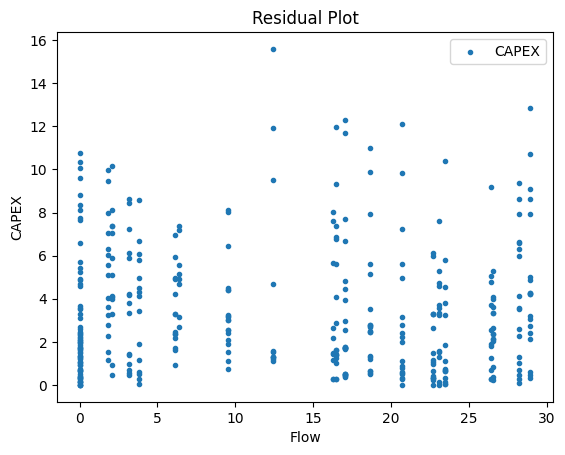

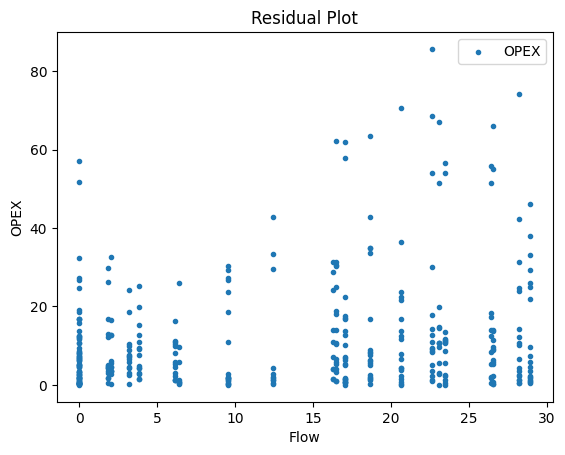

In [6]:
surrogate_scatter2D(
    keras_surrogate, data_training, filename="keras_train_scatter2D.pdf"
)
surrogate_parity(keras_surrogate, data_training, filename="keras_train_parity.pdf")
surrogate_residual(keras_surrogate, data_training, filename="keras_train_residual.pdf")

surrogate_scatter2D(keras_surrogate, data_testing, filename="keras_test_scatter2D.pdf")
surrogate_parity(keras_surrogate, data_testing, filename="keras_test_parity.pdf")
surrogate_residual(keras_surrogate, data_testing, filename="keras_test_residual.pdf")